In [1]:
## Importing Libraries

import numpy as np
import pandas as pd
import csv
from scipy.stats import norm
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import random 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

In [2]:
## Loading the data from the file

data = pd.read_csv('/Users/sumedha/Desktop/VLSI_Project/dataset.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
## Loading the data for each subset

def load_data(filename):
        for line in reader:
            subset_id = int(float(line[0]))
            x = np.array([float(a) for a in line[1:-1]])
            y = float(line[-1])

            if subset_id not in data:
                data[subset_id] = ([], [])

            data[subset_id][0].append(x)
            data[subset_id][1].append(y)
            
            ## Converting lists to numpy arrays
            for subset_id in data.iterkeys():
                x, y = data[subset_id]
                data[subset_id] = (np.array(x), np.array(y))
            return data

In [4]:
## Creating pipelines for the model

class MixtureModel(object):
    def __init__(self, assignments, component_weights, coefficients, variances):
        self.assignments = assignments
        self.component_weights = component_weights
        self.coefficients = coefficients
        self.variances = variances

In [5]:
## Creating Pipelines for the Model result

class MixtureResults(object):
    def __init__(self, num_components):
        self.num_components = num_components
        self.iterations = []
        self.log_likelihoods = []
        self.best = None

    def add_iteration(self, assignments, component_weights, coefficients, variances, data_log_likelihood):
        self.iterations.append(MixtureModel(assignments, component_weights, coefficients, variances))
        self.log_likelihoods.append(data_log_likelihood)

    def finish(self):
        self.log_likelihoods = np.array(self.log_likelihoods)
        self.best = self.iterations[np.argmax(self.log_likelihoods)]

In [6]:
## Assigning weights to the dataset

def weights(x, y, weights, coefficients):
    result = 0
    for i in xrange(len(y)):
        result += weights[i] * (y[i] - x[i].T.dot(coefficients)) ** 2
    return result / weights.sum()

In [7]:
## Assigning each set of points to a component

from sklearn.cluster import KMeans 
def calculate_assignments(assignment_weights, stochastic):

    if stochastic:
        return np.array([np.random.choice(len(row),p=row) for row in assignment_weights])
    return np.argmax(assignment_weights, axis=1)

In [8]:
## Determining probability for each component to generate each set of points

def calculate_assignment_weights(data, keys, component_weights, coefficients, variances):

    num_components = len(component_weights)

    # Initializing the new assignment weights
    assignment_weights = np.ones((len(data), num_components), dtype=float)

    # Calculating the new weights for every set of points
    for i,key in enumerate(keys):
        x, y = data[key]
        for xi, yi in zip(x, y):
            mu = np.array([xi.dot(b) for b in coefficients])
            sigma = np.array([np.sqrt(v) for v in variances])
            temp_weights = norm.pdf(yi, loc=mu, scale=sigma)
            assignment_weights[i] *= temp_weights / temp_weights.sum()
            assignment_weights[i] /= assignment_weights[i].sum()
        assignment_weights[i] *= component_weights
        assignment_weights[i] /= assignment_weights[i].sum()   
    return assignment_weights

In [9]:
## Calculating the parameter values that maximize the likelihood of the data

def maximum_likelihood_parameters(data, keys, num_components, num_features, assignments, assignment_weights):
    # Calculating the weight of each component in the mixture
    component_weights = np.array([(assignments == i).sum() for i in xrange(num_components)]) / float(len(assignments))
    
    # Calculating the regression coefficients and variance for each component
    coefficients = np.zeros((num_components, num_features))
    variances = np.zeros(num_components)
    for i in xrange(num_components):
        points = np.where(assignments == i)[0]
        subset_weights = assignment_weights[points][:,i]
        if len(points) == 0:
            points = np.random.choice(len(assignments), size=np.random.randint(1, len(assignments)), replace=False)
            subset_weights = np.ones(len(points)) / float(len(points))
        component_x = []
        component_y = []
        weights = []
        for key, subset_weight in zip(keys[points], subset_weights):
            x, y = data[key]
            component_x.extend(x)
            component_y.extend(y)
            weights.extend([subset_weight / float(len(y))] * len(y))
        component_x = np.array(component_x)
        component_y = np.array(component_y)
        weights = np.array(weights)
        coefficients[i] = weighted_linear_regression(component_x, component_y, weights)
        variances[i] = weighted_regression_variance(component_x, component_y, weights, coefficients[i])
    return (component_weights, coefficients, variances)

In [10]:
## Fitting the Mixture Model

def fit_with_restarts_worker(worker_params):
    data, keys, num_components, max_iterations, num_restarts, stochastic, verbose = worker_params
    return fit_with_restarts(data, keys, num_components, max_iterations, num_restarts, stochastic=stochastic, verbose=verbose)

In [11]:
## Saving the result

def save_results(results, keys, filename):
    with open(filename, 'wb') as f:
        writer = csv.writer(f)
        writer.writerow([results.num_components])
        best = results.best
        print('component_weights: {0} coefficients: {1} variances: {2}'.format(best.component_weights.shape, best.coefficients.shape, best.variances.shape)) 
        rows = np.zeros((results.num_components, best.coefficients.shape[1] + 2))
        rows[:,0] = best.component_weights
        rows[:,1:1+best.coefficients.shape[1]] = best.coefficients
        rows[:,1+best.coefficients.shape[1]] = best.variances
        writer.writerows(rows)
        for key, assignment in zip(keys, best.assignments):
            writer.writerow([key, assignment])

In [12]:
## Chooseing parameter values for the algorithm

# Number of mixture components
num_components = 3 
# Maximum iterations per run
max_iterations = 20 
# Number of random restarts to try
num_restarts = 5 
# Using stochastic process
stoachastic = False
# Number of worker processes to use
num_workers = 4 

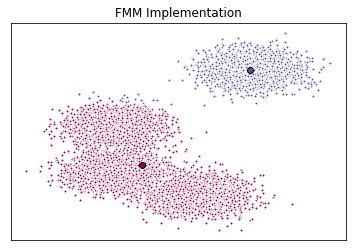

In [13]:

X, y = make_blobs(n_samples=8000, centers=[[-1,3], [4, 8], [2, -3], [-1, -1]], cluster_std=0.9)
fmm = KMeans(init = "k-means++", n_clusters = 2, n_init = 100)
fmm.fit(X)
fmm_labels = fmm.labels_
fmm_labels
fmm_centers = fmm.cluster_centers_
fmm_centers
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(fmm_labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):
    my_members = (fmm_labels == k)
    cluster_center = fmm_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('FMM Implementation')
ax.set_xticks(())
ax.set_yticks(())

# Show the plot
plt.show()